In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt


## Data Preparation (✅ 60/20/20 Split)

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

# Replace missing values
for c in df.columns:
    if df[c].dtype == 'O':  # categorical
        df[c] = df[c].fillna('NA')
    else:  # numerical
        df[c] = df[c].fillna(0.0)

# Define target
y = df.converted.values
df = df.drop('converted', axis=1)

In [3]:
# ---- FIRST SPLIT (train vs temp: 60% / 40%) ----
df_train, df_temp, y_train, y_temp = train_test_split(
    df, y, test_size=0.4, random_state=1
)

# ---- SECOND SPLIT (val vs test: 20% / 20%) ----
df_val, df_test, y_val, y_test = train_test_split(
    df_temp, y_temp, test_size=0.5, random_state=1
)

# Check proportions
print(f"Train size: {len(df_train)/len(df):.2f}")
print(f"Validation size: {len(df_val)/len(df):.2f}")
print(f"Test size: {len(df_test)/len(df):.2f}")

Train size: 0.60
Validation size: 0.20
Test size: 0.20


## Question 1: ROC AUC Feature Importance

In [4]:
num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
roc_values = {}

for c in num_cols:
    auc = roc_auc_score(y_train, df_train[c])
    # If negative correlation, flip sign
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    roc_values[c] = auc

print("ROC AUC per numeric feature:")
for k, v in roc_values.items():
    print(f"{k}: {v:.3f}")


ROC AUC per numeric feature:
lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545


## Question 2: Train Logistic Regression

In [6]:
# One-hot encode
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Validation AUC
y_pred_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)
print("Validation AUC:", round(auc_val, 3))


Validation AUC: 0.794


## Question 3: Precision and Recall Curves

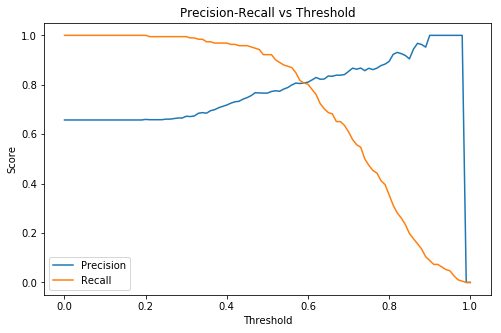

Precision–Recall intersection threshold: 0.59


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_pred_val >= t)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

# Plot Precision and Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.show()

# Find where curves intersect (closest values)
diff = np.abs(np.array(precisions) - np.array(recalls))
threshold_intersect = thresholds[np.argmin(diff)]
print("Precision–Recall intersection threshold:", round(threshold_intersect, 3))


## Question 4: F1 Score and Best Threshold

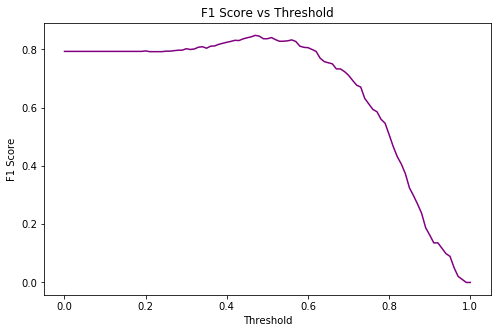

Best F1: 0.848 at threshold: 0.47


In [9]:
f1_scores = []

for p, r in zip(precisions, recalls):
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, color='purple')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

print("Best F1:", round(best_f1, 3), "at threshold:", round(best_threshold, 3))


## Question 5: 5-Fold Cross-Validation

In [11]:
# Combine training and validation sets into full training data
df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_k = df_full_train.iloc[train_idx]
    df_val_k = df_full_train.iloc[val_idx]
    y_train_k = y_full_train[train_idx]
    y_val_k = y_full_train[val_idx]
    
    # Encode
    dv = DictVectorizer(sparse=False)
    X_train_k = dv.fit_transform(df_train_k.to_dict(orient='records'))
    X_val_k = dv.transform(df_val_k.to_dict(orient='records'))
    
    # Train
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_k, y_train_k)
    
    # Predict & evaluate
    y_pred_k = model.predict_proba(X_val_k)[:, 1]
    auc = roc_auc_score(y_val_k, y_pred_k)
    scores.append(auc)

print("AUC scores per fold:", [round(s, 3) for s in scores])
print("Mean AUC:", round(np.mean(scores), 3))
print("Std Dev:", round(np.std(scores), 3))


AUC scores per fold: [0.807, 0.807, 0.865, 0.833, 0.815]
Mean AUC: 0.825
Std Dev: 0.022


## Question 6: Hyperparameter Tuning (C Values)

In [12]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]
        y_train_k = y_full_train[train_idx]
        y_val_k = y_full_train[val_idx]
        
        dv = DictVectorizer(sparse=False)
        X_train_k = dv.fit_transform(df_train_k.to_dict(orient='records'))
        X_val_k = dv.transform(df_val_k.to_dict(orient='records'))
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_k, y_train_k)
        y_pred_k = model.predict_proba(X_val_k)[:, 1]
        auc = roc_auc_score(y_val_k, y_pred_k)
        scores.append(auc)
    
    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)
    results.append((C, mean_score, std_score))

for r in results:
    print(f"C={r[0]:.6f} -> mean={r[1]}, std={r[2]}")


C=0.000001 -> mean=0.543, std=0.025
C=0.001000 -> mean=0.864, std=0.014
C=1.000000 -> mean=0.825, std=0.022
